# Betting Strategy

In this notebook, I am evaluating the score prediction models in the context of a betting strategy. Obviously, the goal is to maximize profit using the betting odds of bookmakers. I will test the model using back-testing with refit where for each game-week, the model is trained on all available historical data and makes a prediction for the upcoming game-week. A game-week is the set of all games to be played within the coming calendar week. 

In the English Premier League, there are 38 game-weeks so throughout the back-testing, the model was trained 38 times and made 38 batches of predictions. For each game-week, I saved the batch of predictions which I use throughout the notebook. Here I use *Bet365* as the benchmark bookmaker.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

In [3]:
bookmaker = 'B365'
odds_market = (
    pd.read_csv('../../data/betting/2021-22.csv')
    .loc[:, [
        "HomeTeam", "AwayTeam", "FTHG", "FTAG",
        f"{bookmaker}H", f"{bookmaker}D", f"{bookmaker}A"]]
    .rename(columns={
        "HomeTeam": "team1",
        "AwayTeam": "team2",
        "FTHG": "score1",
        "FTAG": "score2",
        f"{bookmaker}H": "home_win",
        f"{bookmaker}D": "draw",
        f"{bookmaker}A": "away_win"})
)

odds_market = odds_market.replace({
    'Brighton': 'Brighton and Hove Albion',
    'Leicester': 'Leicester City',
    'Leeds': 'Leeds United',
    'Man City': 'Manchester City',
    'Man United': 'Manchester United',
    'Norwich': 'Norwich City',
    'Tottenham': 'Tottenham Hotspur',
    'West Ham': 'West Ham United',
    'Wolves': 'Wolverhampton'
})

In [4]:
# Get the model predictions.
outcome = pd.read_csv("../../data/fivethirtyeight/spi_matches.csv")
outcome = (
    outcome
        .loc[
            (outcome['league_id'] == 2411) |
            (outcome['league_id'] == 2412)]
        .dropna()
    )

predictions_dixon_coles = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/dixon_coles.csv"),
        outcome.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_spi = pd.read_csv("../../data/fivethirtyeight/spi_matches.csv")
predictions_spi = (
    predictions_spi
    .loc[predictions_spi['league_id'] == 2411]
    .rename(columns={
        "prob1": "home_win_p",
        "probtie": "draw_p",
        "prob2": "away_win_p"})
    .loc[:, [
        'team1', 'team2', 'home_win_p', 'draw_p',
        'away_win_p', 'score1', 'score2']]
    .loc[predictions_spi['season'] == 2021]
    .loc[predictions_spi['score1'].notna()]
    )

In [5]:
df_dc = (
    pd.merge(
        predictions_dixon_coles.loc[:, [
            'team1', 'team2', 'home_win_p', 'draw_p', 'away_win_p']],
        odds_market,
        how='left',
        left_on=['team1', 'team2'],
        right_on=['team1', 'team2'])
    .dropna()
    )

df_spi = (
    pd.merge(
        predictions_spi.loc[:, [
            'team1', 'team2', 'home_win_p', 'draw_p', 'away_win_p']],
        odds_market,
        how='left',
        left_on=['team1', 'team2'],
        right_on=['team1', 'team2'])
    .dropna()
    )

In [6]:
from ranked_probability_score import match_outcome

df_dc['winner'] = match_outcome(df_dc)
df_spi['winner'] = match_outcome(df_spi)

## Kelly Criterion

The first betting strategy I implement is based on the expected value of outcomes and the Kelly criterion. To maximize profit we will compute the expectation of a bet, or the average payoff one can expect to receive. Let us express it mathematically for event an A (where A $\in \{Home, Draw, Away\}$) such that $w_A$ is the wager placed on that outcome, $o_A$ is the bookmaker odds for that outcome and $\overline{A}$ is the set of all outcomes excluding $A$ and finally $P(A)$ the estimated probability of event $A$ occurring:

$$ EV(A) = w_A \times o_A \times P(A) + \sum_{e \in \overline{A}} P(e) \times 0 - w_A = o_A \times P(A) - 1 $$

In [7]:
def excepted_value(p_win, gain):
    return p_win * gain - (1 - p_win) * 0

df_dc['ev_h'] = df_dc.apply(
    lambda row: excepted_value(row['home_win_p'], row['home_win']), axis=1)
df_dc['ev_d'] = df_dc.apply(
    lambda row: excepted_value(row['draw_p'], row['draw']), axis=1)
df_dc['ev_a'] = df_dc.apply(
    lambda row: excepted_value(row['away_win_p'], row['away_win']), axis=1)

df_spi['ev_h'] = df_spi.apply(
    lambda row: excepted_value(row['home_win_p'], row['home_win']), axis=1)
df_spi['ev_d'] = df_spi.apply(
    lambda row: excepted_value(row['draw_p'], row['draw']), axis=1)
df_spi['ev_a'] = df_spi.apply(
    lambda row: excepted_value(row['away_win_p'], row['away_win']), axis=1)

Now that we have identified a bet that we expect will yield a positive payoff, we have to determine the amount to stake on it. Betting the entire balance on a single event might seem appealing since if it occurs the payoff will be the maximum possible but if it does not, one does not have new betting opportunities. Managing the account balance for betting is about acknowledging the randomness of the outcomes and allowing oneself to have to margin for error. Some strategies have been elaborated to maximize wealth growth over time for investing and could be used in the context of gambling. The Kelly Criterion is one mathematical formula used to determine the optimal amount of money to put into a single bet. The strength of the Kelly Criterion is the fact that it takes into account the likelihood of the event as well as the payoff. Thus it is a formula that balances the uncertainty and randomness (or the risk) with the payoff (i.e. the reward). The formula is the following:

$$ K(A) = P(A) - \frac{1 - P(A)}{o_A - 1}$$

In [8]:
def kelly_criterion(p, q):
    return p + (p - 1) / (q - 1)

df_dc['k_h'] = df_dc.apply(
    lambda row: kelly_criterion(row['home_win_p'], row['home_win']), axis=1)
df_dc['k_d'] = df_dc.apply(
    lambda row: kelly_criterion(row['draw_p'], row['draw']), axis=1)
df_dc['k_a'] = df_dc.apply(
    lambda row: kelly_criterion(row['away_win_p'], row['away_win']), axis=1)

df_spi['k_h'] = df_spi.apply(
    lambda row: kelly_criterion(row['home_win_p'], row['home_win']), axis=1)
df_spi['k_d'] = df_spi.apply(
    lambda row: kelly_criterion(row['draw_p'], row['draw']), axis=1)
df_spi['k_a'] = df_spi.apply(
    lambda row: kelly_criterion(row['away_win_p'], row['away_win']), axis=1)

In [9]:
def bet(row):
    global account_balance

    # Get highest potential event
    evs = np.array([row['ev_h'], row['ev_d'], row['ev_a']])
    edge = np.argmax(evs)

    start = account_balance
    # Ensure its profitable
    if evs[edge] > 1:
        
        # Get bet amount
        k = np.array([row['k_h'], row['k_d'], row['k_a']])[edge]
        # Ensure we bet a positive amount
        if k > 0:
            bet_value = k * account_balance
            account_balance -= bet_value

            # Get result of the bet
            if edge == row['winner'] == 0:
                account_balance += bet_value * row['home_win']

            elif edge == row['winner'] == 1:
                account_balance += bet_value * row['draw']

            elif edge == row['winner'] == 2:
                account_balance += bet_value * row['away_win']

    return (
        account_balance,
        edge if evs[edge] > 1 else -1,
        0 if account_balance > start else 1 if account_balance == start else 2
        )

account_balance = 100
(
    df_dc['balance'], 
    df_dc['bet_placed'],
    df_dc['bet_outcome']
    ) = zip(*df_dc.apply(bet, axis=1))
account_balance = 100
(
    df_spi['balance'],
    df_spi['bet_placed'],
    df_spi['bet_outcome']) = zip(*df_spi.apply(bet, axis=1))

Well, it turns out that my model is not yet ready to beat the odds. 🤣

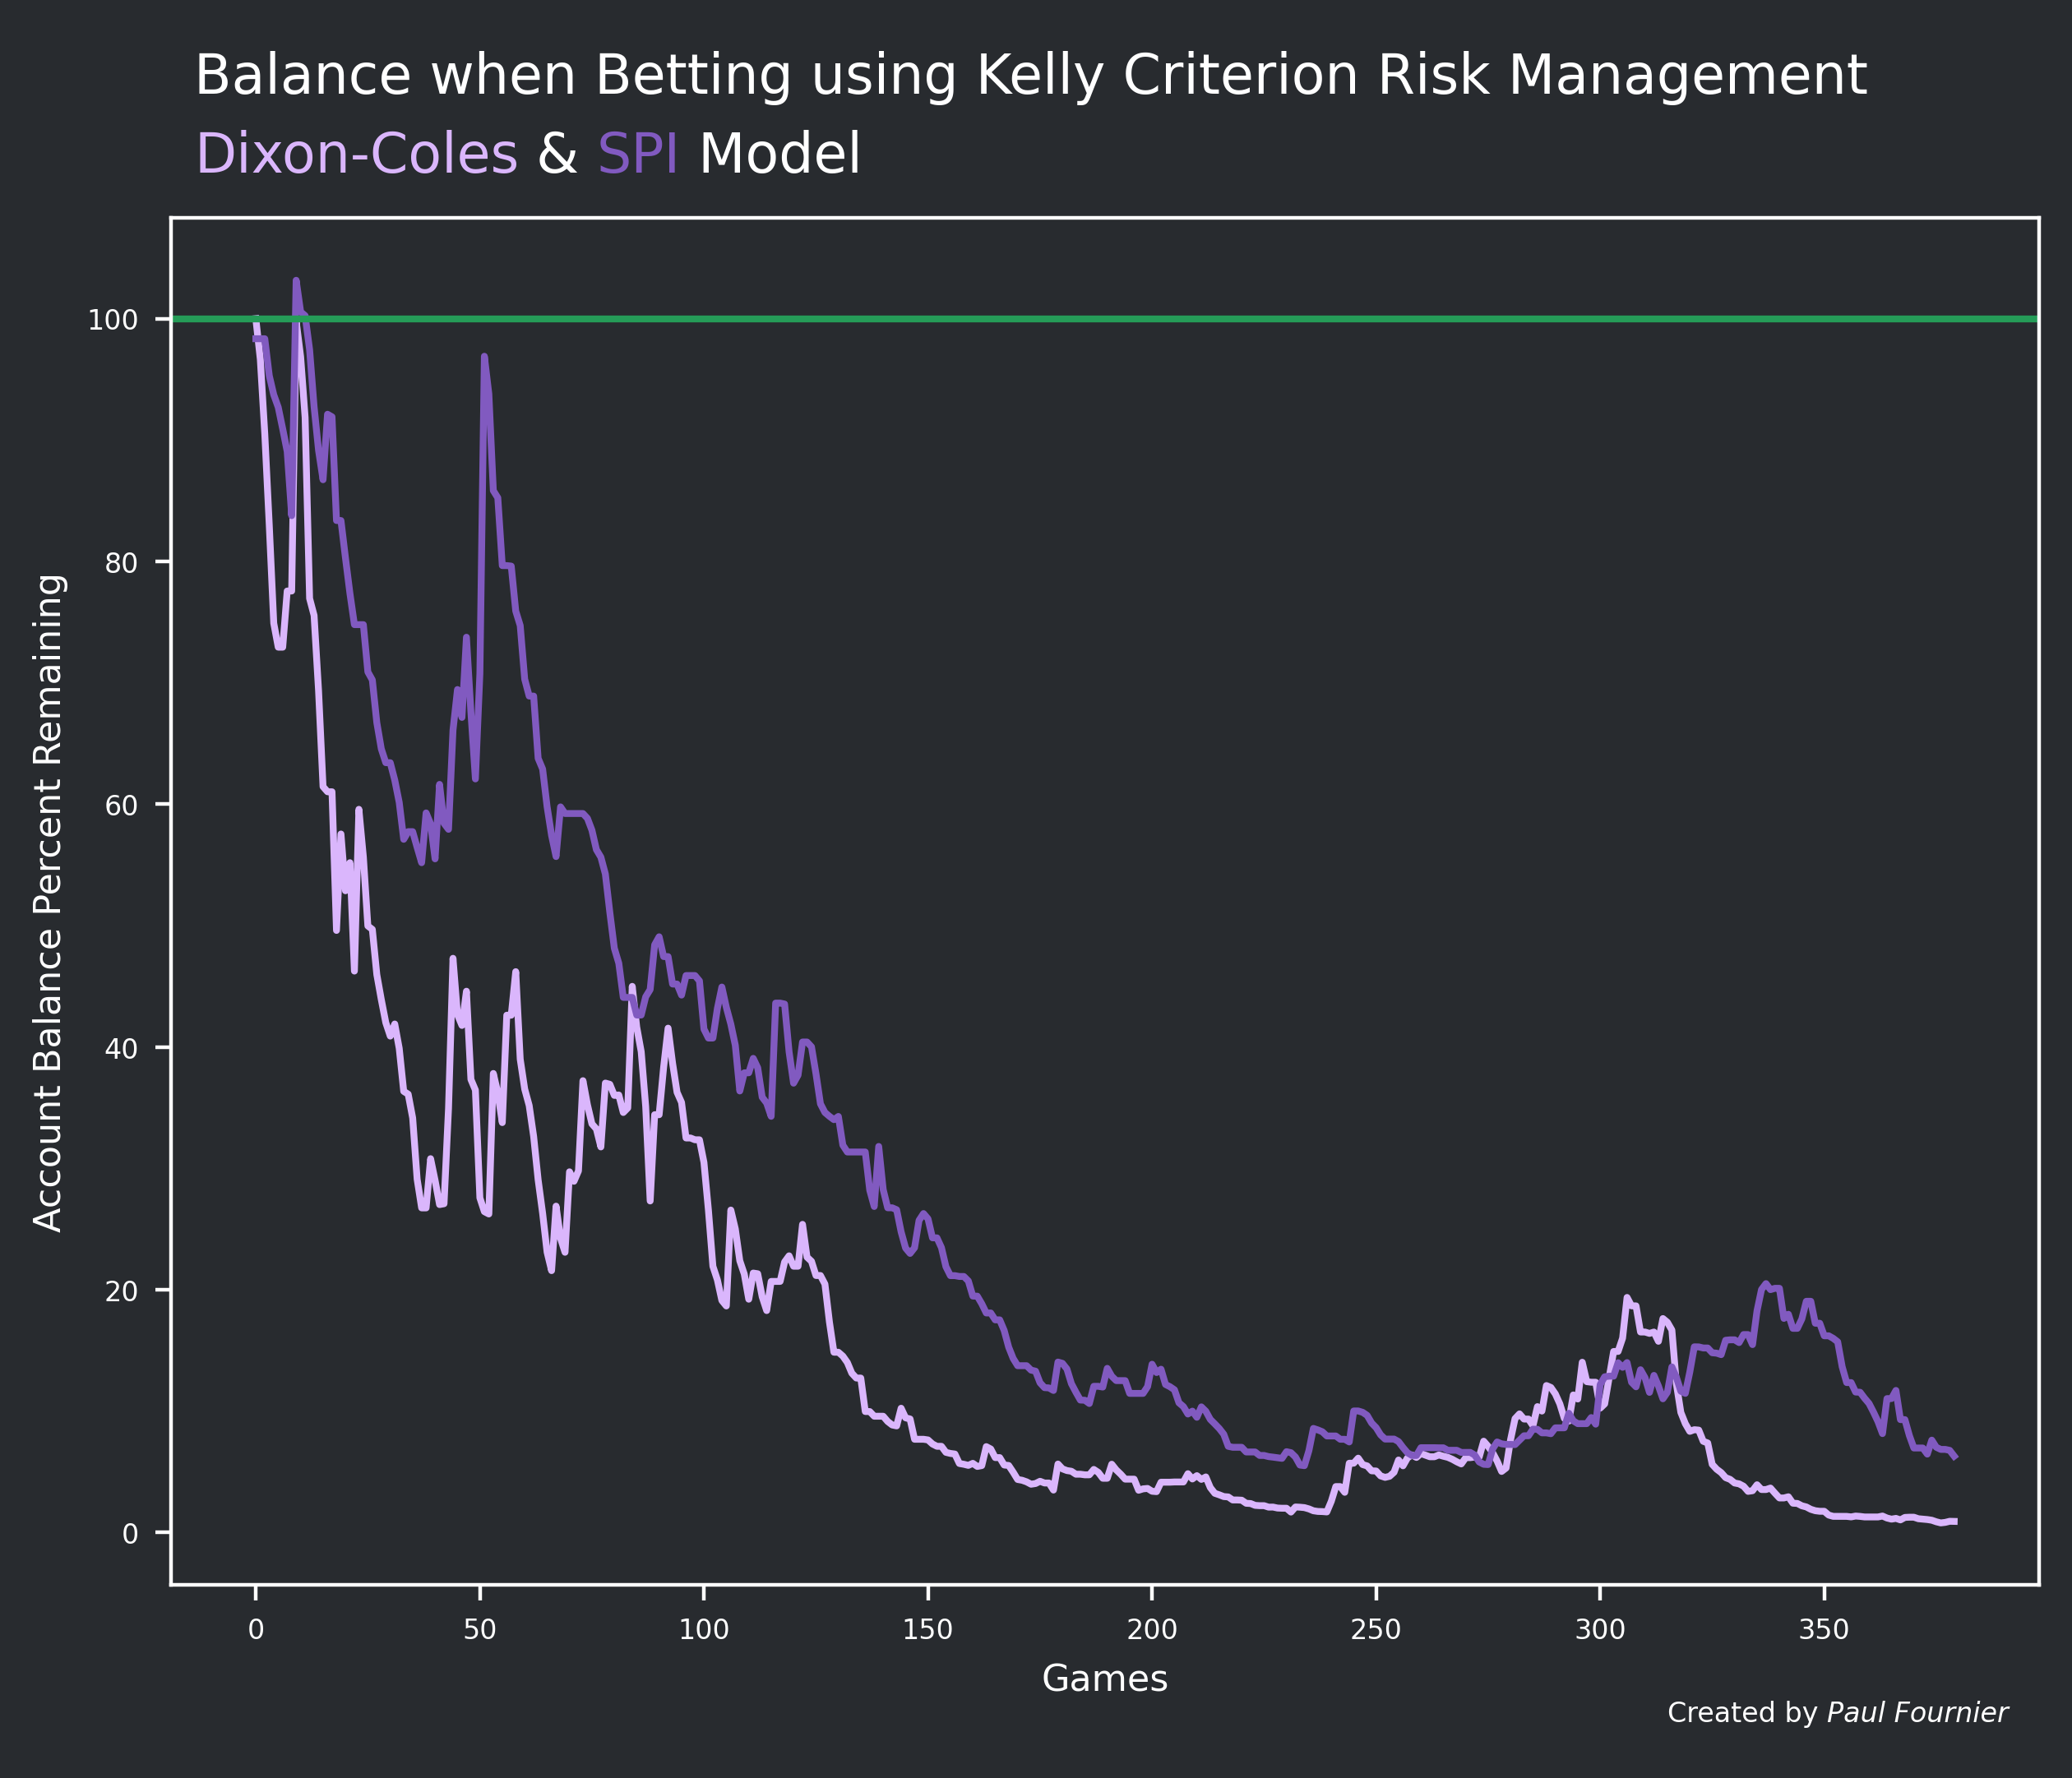

In [30]:
fig, ax = plt.subplots(tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(df_dc.balance.shift(1).fillna(100), color='#dab6fc')
ax.plot(df_spi['balance'], color='#815ac0')

plt.axhline(y = 100, color = '#259C58', linestyle = '-')

ax.set_xlabel('Games', fontsize=8, color=text_color)
ax.set_ylabel('Account Balance Percent Remaining' , fontsize=8, color=text_color)

fig_text(
    x=0.1, y=1.075,
    s="Balance when Betting using Kelly Criterion Risk Management",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.1, y=1.025,
    s="<Dixon-Coles> & <SPI> Model",
    highlight_textprops=[
            {"color": '#dab6fc'},
            {"color": '#815ac0'}
        ],
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.03,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

In [17]:
f"Total bets placed on \
Home: {np.sum(df_dc.bet_placed == 0)}, \
Draw: {np.sum(df_dc.bet_placed == 1)}, \
Away win: {np.sum(df_dc.bet_placed == 2)}"

'Total bets placed on Home: 91, Draw: 13, Away win: 224'

In [18]:
f"""Total bets \
Won: {np.sum(df_dc.bet_outcome == 0)}, \
Lost: {np.sum(df_dc.bet_outcome == 2)}, \
Ignored: {np.sum(df_dc.bet_outcome == 1)}"""

'Total bets Won: 90, Lost: 238, Ignored: 52'

### Sample Betting Example

Show the betting logic on a single game.

In [25]:
sample = df_dc.loc[(df_dc.team1 == 'Liverpool') & (df_dc.team2 == 'Wolverhampton')]

ev_h = sample.apply(
    lambda row: excepted_value(row['home_win_p'], row['home_win']), axis=1)
ev_d = sample.apply(
    lambda row: excepted_value(row['draw_p'], row['draw']), axis=1)
ev_a = sample.apply(
    lambda row: excepted_value(row['away_win_p'], row['away_win']), axis=1)

# Betting on a draw has the highest Expected Value
pd.DataFrame({
    'Home': ev_h.values,
    'Draw': ev_d.values,
    'Away': ev_a.values})

,Home,Draw,Away
0,0.769981,1.758363,1.752104


For this game, the expected value is highest for the draw, so the optimal bet amount is the maximum of the ploted line below in below (shown with the green vertical line).

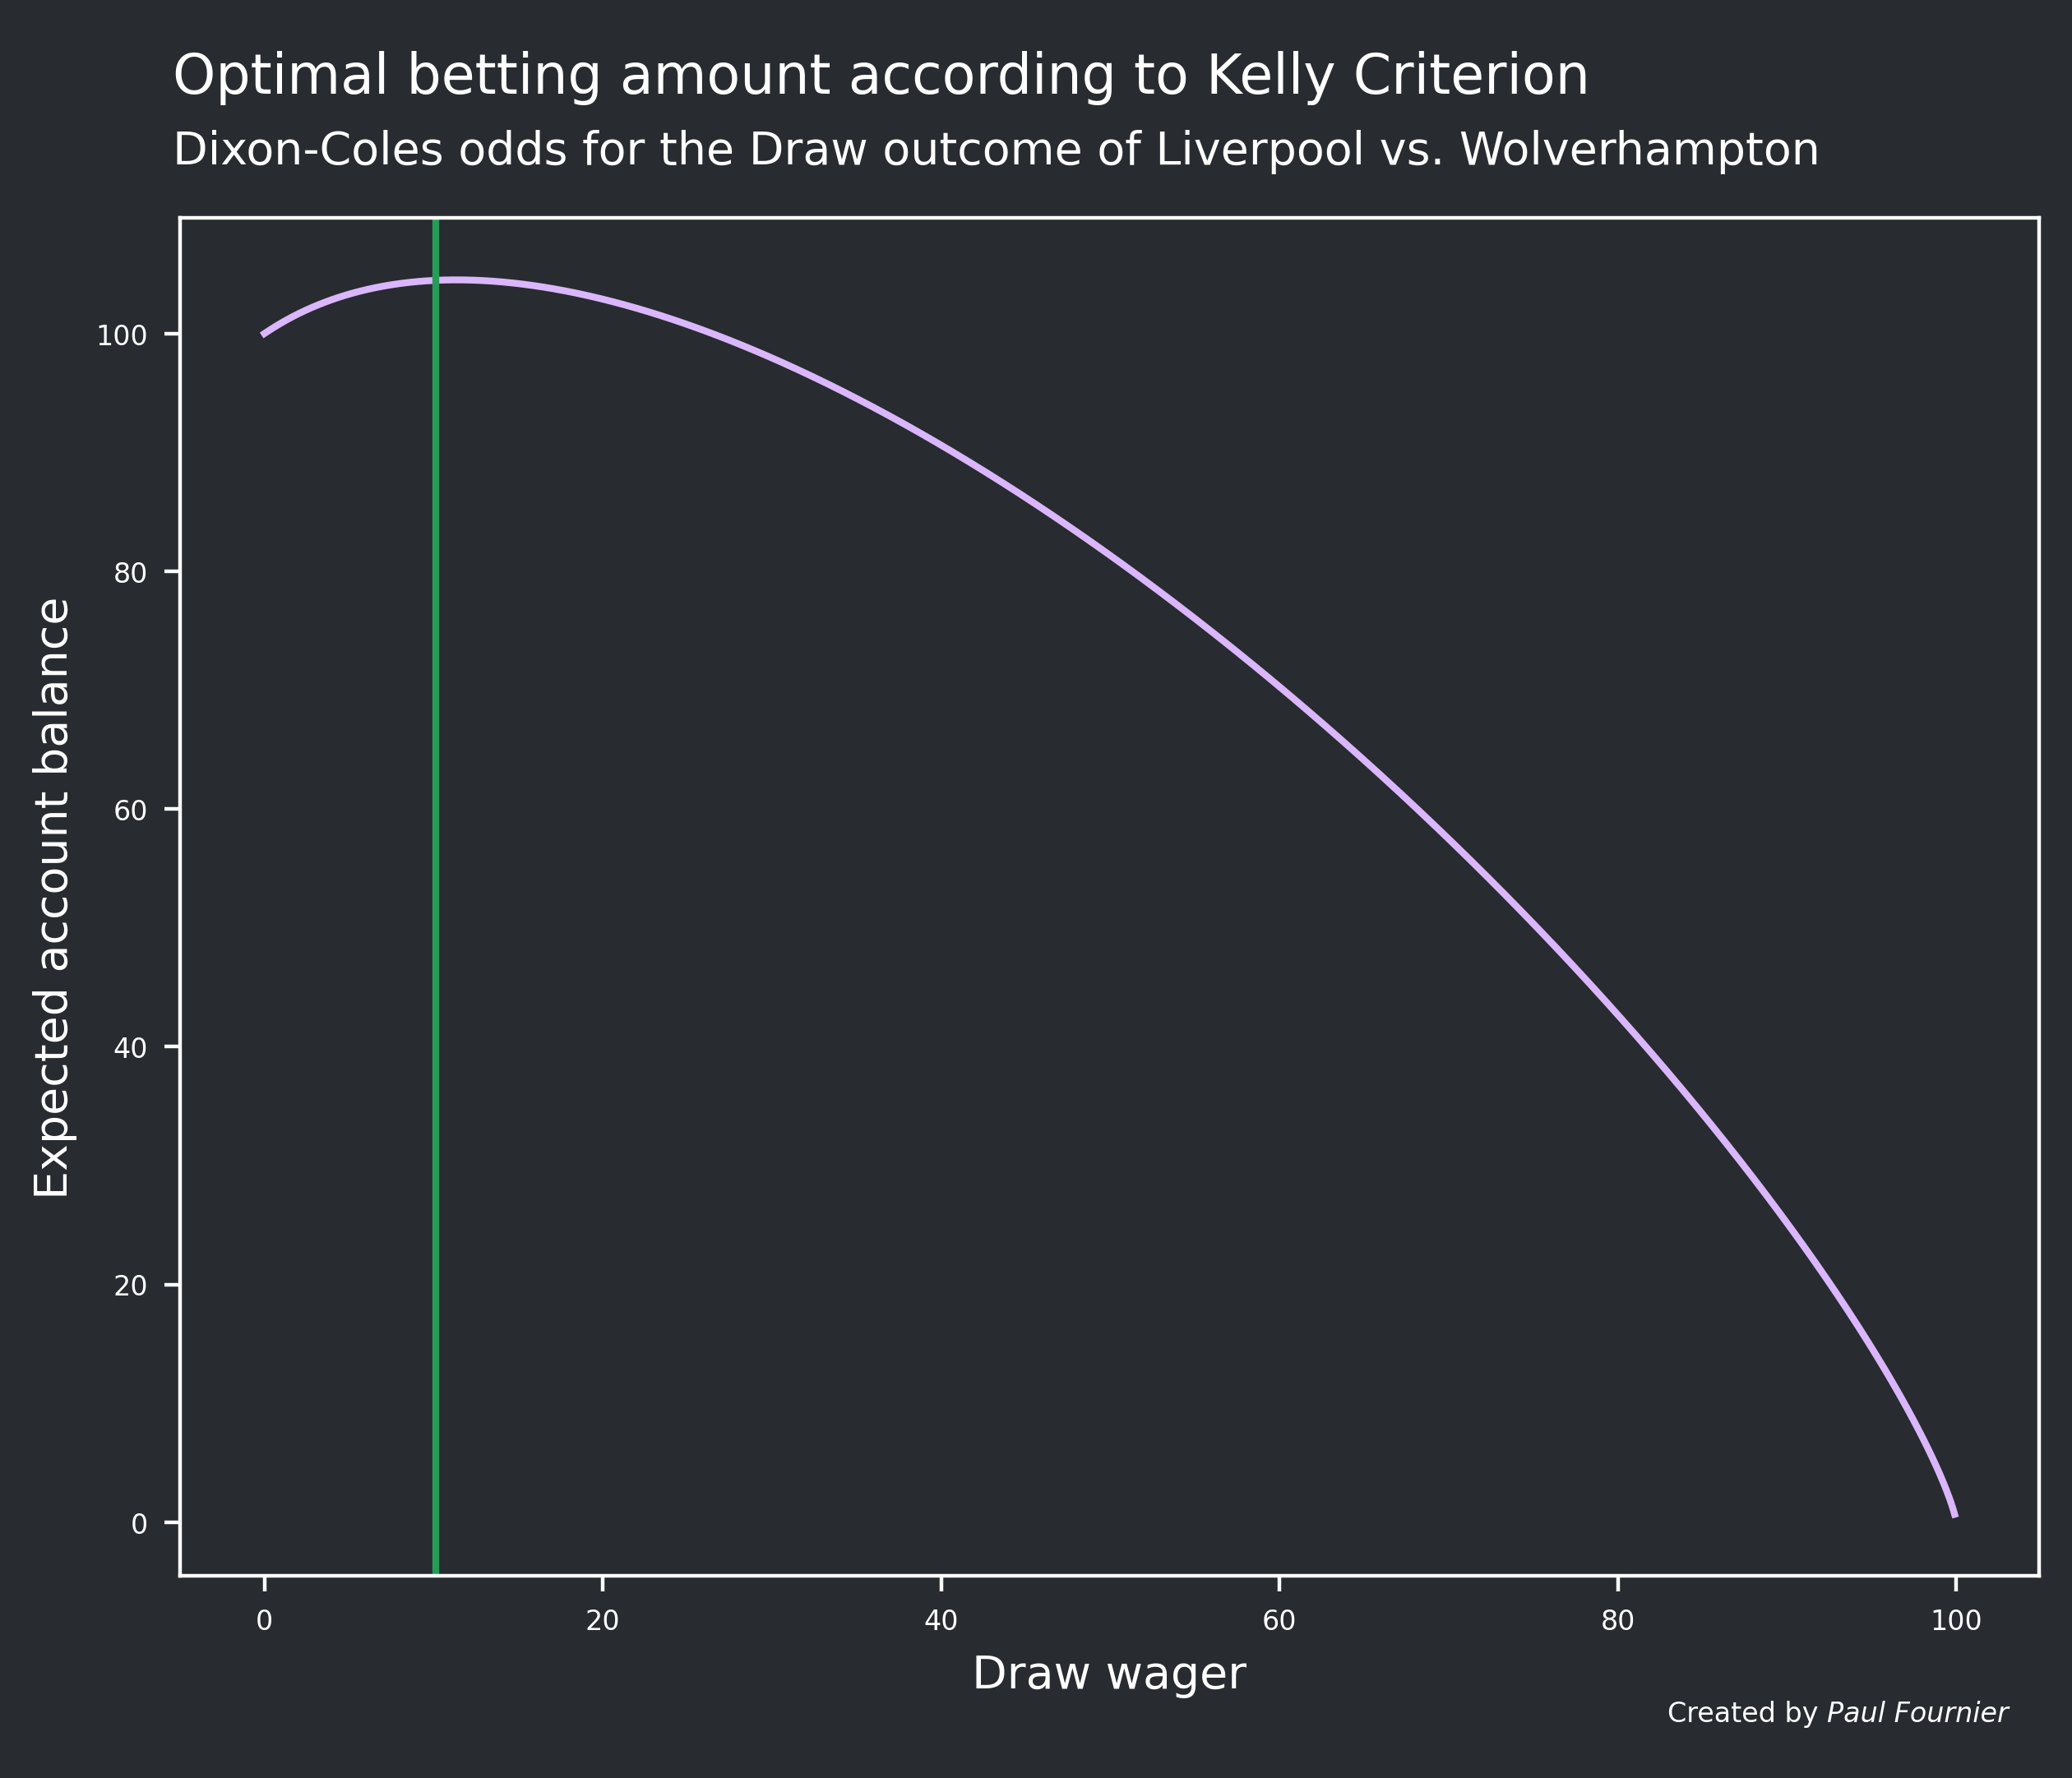

In [31]:
fig, ax = plt.subplots(tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(
    np.arange(0, 100, 0.1),
    (
        np.power(
            100 + np.arange(0, 100, 0.1) * sample.draw.values[0],
            sample.draw_p.values[0])
        ) *
    (
        np.power(
            100 - np.arange(0, 100, 0.1),
            1 - sample.draw_p.values[0])
        ),
    color = '#dab6fc',
    label='Growth curve')

plt.axvline(
    x = sample.apply(lambda row: kelly_criterion(row['draw_p'], row['draw']), axis=1).values[0] * 100,
    color = '#259C58', linestyle = '-', label='Maximum')

ax.set_xlabel('Draw wager')
ax.xaxis.label.set_color('w')
ax.set_ylabel('Expected account balance')
ax.yaxis.label.set_color('w')

fig_text(
    x=0.09, y=1.075,
    s="Optimal betting amount according to Kelly Criterion",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.09, y=1.025,
    s="Dixon-Coles odds for the Draw outcome of Liverpool vs. Wolverhampton",
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.03,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

## Kelly Criterion Optimization

Now, I will identify the best betting opportunity by maximizing the expected account balance (after placing bets and getting the payoff.

The formula for the Kelly criterion I wrote before actually only applies for events where only two outcomes are possible. This simplified formula does not work especially given that per event, only a single bet is place (on the highest expected value event). Thus I explored the Kelly criterion formula when generalized to a multiple outcome case and will develop the mathematics its relies on. We want to maximize:

$$r = \prod_{i \in (h, d, a)} (1 + K_i \times o_i - \sum_{j \in (h, d, a)} K_j)^{p_i}$$

which is the growth rate when betting on outcome $i$ with betting odds $o_i$ and probability $p_i$. This is equivalent to finding the maximum of the logarithm of this formula: 

$$ E = log(r) = \sum_{i \in (h, d, a)} p_i log(1 + K_i \times o_i - \sum_{j \in (h, d, a)} K_j) $$

The maximum of this formula is given by the value for which its derivative equals zero. When there are only two events, the maximum is equal to the Kelly Criterion formula shown before. For multi-outcome betting, we can find the maximum simply using optimization libraries.

In [33]:
from scipy.optimize import minimize

def kco(parameters, odds, predictions, balance):
    ending_bankroll = np.zeros(3) + balance

    # parameters = np.where(parameters<0.1, 0, parameters)

    winnings = parameters * odds # Compute conditional winnings
    losses = np.sum(parameters) # Enter wager

    ending_bankroll += winnings
    ending_bankroll -= losses

    return - (
        np.log(ending_bankroll) * 
        predictions).sum()

def bet(row):
    global account_balance
    parameters = np.concatenate((
        np.zeros(3),  # Betting amount
    ))
    odds =  np.array([
        row.home_win,
        row.draw,
        row.away_win])
    predictions =  np.array([
        row.home_win_p,
        row.draw_p,
        row.away_win_p])

    # Force total betting amount to be below or equal to 100
    constraints = (
        {
            "type": "ineq",
            "fun": lambda x:
                - sum(x) + account_balance },
        )

    bounds = [(0, account_balance)] * 3
    start = account_balance

    solution = minimize(
        kco,
        parameters,
        args=(odds, predictions, account_balance),
        constraints=constraints,
        bounds=bounds,
        options={'disp': False, 'maxiter': 1000}
        )
    bet_amount = solution['x']

    # Remove all wagers from the account
    account_balance -= bet_amount[0] if bet_amount[0] >= 0.1 else 0
    account_balance -= bet_amount[1] if bet_amount[1] >= 0.1 else 0
    account_balance -= bet_amount[2] if bet_amount[2] >= 0.1 else 0

    # Get result of the bet
    if (bet_amount[0] >= 0.1) & (row['winner'] == 0):
        account_balance += bet_amount[0] * odds[0]

    if (bet_amount[1] >= 0.1) & (row['winner'] == 1):
        account_balance += bet_amount[1] * odds[1]

    if (bet_amount[2] >= 0.1) & (row['winner'] == 2):
        account_balance += bet_amount[2] * odds[2]

    return (
        account_balance,
        (bet_amount[0] if bet_amount[0] >= 0.1 else 0),
        (bet_amount[1] if bet_amount[1] >= 0.1 else 0),
        (bet_amount[2] if bet_amount[2] >= 0.1 else 0),
        0 if account_balance > start else 1 if account_balance == start else 2
        )

account_balance = 100
(
    df_dc['balance'],
    df_dc['wager_h'],
    df_dc['wager_d'],
    df_dc['wager_a'],
    df_dc['bet_outcome']
    ) = zip(*df_dc.apply(bet, axis=1))

account_balance = 100
(
    df_spi['balance'],
    df_spi['wager_h'],
    df_spi['wager_d'],
    df_spi['wager_a'],
    df_spi['bet_outcome']
    ) = zip(*df_spi.apply(bet, axis=1))

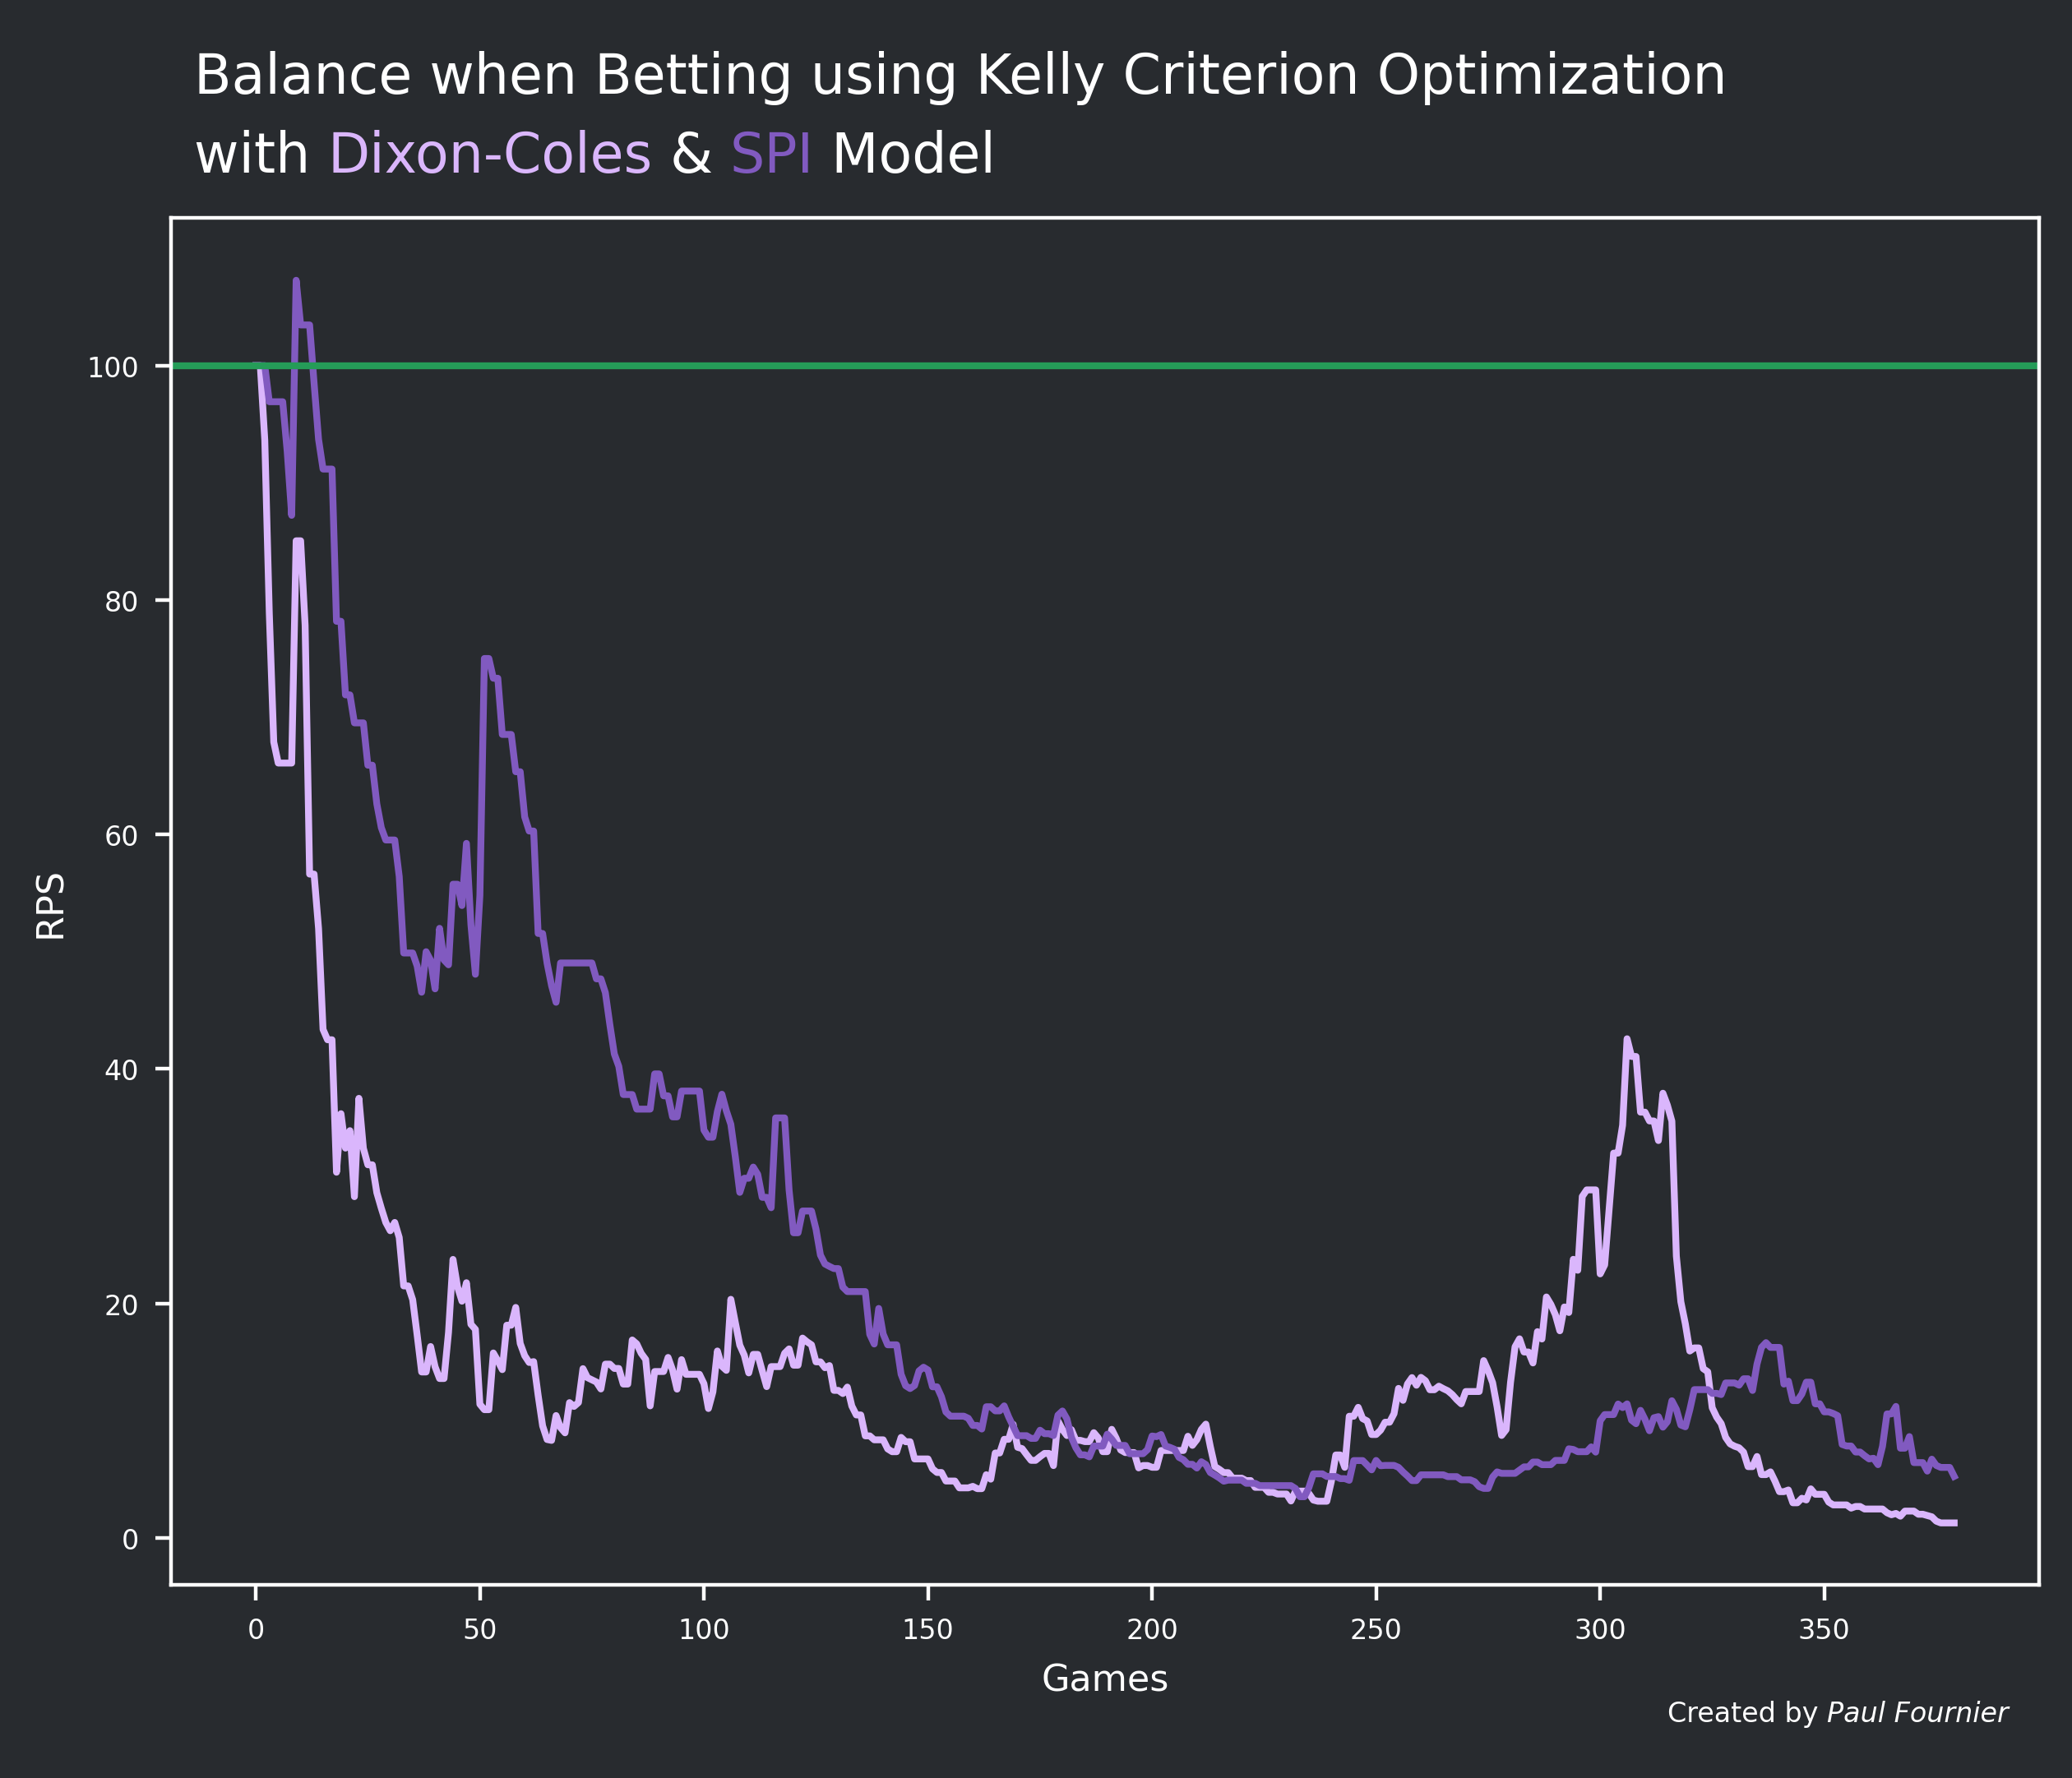

In [34]:
fig, ax = plt.subplots(tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(df_dc.balance.shift(1).fillna(100), color='#dab6fc')
ax.plot(df_spi['balance'], color='#815ac0')

plt.axhline(y = 100, color = '#259C58', linestyle = '-')

ax.set_xlabel('Games', fontsize=8, color=text_color)
ax.set_ylabel('Account Balance Percent Remaining', fontsize=8, color=text_color)

fig_text(
    x=0.1, y=1.075,
    s="Balance when Betting using Kelly Criterion Optimization",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.1, y=1.025,
    s="with <Dixon-Coles> & <SPI> Model",
    highlight_textprops=[
            {"color": '#dab6fc'},
            {"color": '#815ac0'},
        ],
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.03,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

In [38]:
f"""Total bets placed on \
Home: {np.sum(df_dc.wager_h > 0)}, \
Draw: {np.sum(df_dc.wager_d > 0)}, \
Away: {np.sum(df_dc.wager_a > 0)}"""

'Total bets placed on Home: 69, Draw: 126, Away: 197'

In [36]:
f"""Total bets \
Won: {np.sum(df_dc.bet_outcome == 0)}, \
Lost: {np.sum(df_dc.bet_outcome == 2)}, \
Ignored: {np.sum(df_dc.bet_outcome == 1)}"""

'Total bets Won: 90, Lost: 183, Ignored: 107'

In [39]:
f"""Total number of multi bets placed: {(
    np.sum((df_dc.wager_h > 0) & (df_dc.wager_d > 0)) +
    np.sum((df_dc.wager_h > 0) & (df_dc.wager_a > 0)) +
    np.sum((df_dc.wager_d > 0) & (df_dc.wager_a > 0))
    )}"""

'Total number of multi bets placed: 119'

### Sample Betting Example

Show the betting logic on a single game.

In [43]:
sample = df_dc.loc[(df_dc.team1 == 'Liverpool') & (df_dc.team2 == 'Wolverhampton')]

account_balance = 100
res = sample.apply(bet, axis=1).values[0]
f"""For optimal payoff KCO suggests betting {np.round(res[1], 2)} on Home team, \
{np.round(res[2], 2)} on a Draw and \
{np.round(res[3], 2)} on the Away team."""

'For optimal payoff KCO suggests betting 0 on Home team, 10.96 on a Draw and 6.16 on the Away team.'

In [45]:
d = np.arange(0, 100)
a = np.arange(0, 100)

xgrid, ygrid = np.meshgrid(d, a)
xy = np.stack([xgrid, ygrid])

def kco(parameters, odds, predictions, balance):
    # Bank
    ending_bankroll_home = np.zeros((100, 100)) + balance
    ending_bankroll_draw = np.zeros((100, 100)) + balance
    ending_bankroll_away = np.zeros((100, 100)) + balance
    # Bets per outcome
    bets_home = np.zeros((100, 100))
    bets_draw = parameters[0]
    bets_away = parameters[1]
    # Conditional winning per outcome
    winning_home = bets_home * odds[0]
    winning_draw = bets_draw * odds[1]
    winning_away = bets_away * odds[2]
    # Losses
    losses = bets_home + bets_draw + bets_away

    E = (
        predictions[0] * np.log(ending_bankroll_home + winning_home - losses) +
        predictions[1] * np.log(ending_bankroll_draw + winning_draw - losses) +
        predictions[2] * np.log(ending_bankroll_away + winning_away - losses)
        )

    return E

E = kco(
    xy,
    sample[['home_win', 'draw', 'away_win']].values[0],
    sample[['home_win_p', 'draw_p', 'away_win_p']].values[0],
    100
    )

/tmp/ipykernel_72314/858799538.py:24: RuntimeWarning: divide by zero encountered in log
  predictions[0] * np.log(ending_bankroll_home + winning_home - losses) +
/tmp/ipykernel_72314/858799538.py:24: RuntimeWarning: invalid value encountered in log
  predictions[0] * np.log(ending_bankroll_home + winning_home - losses) +


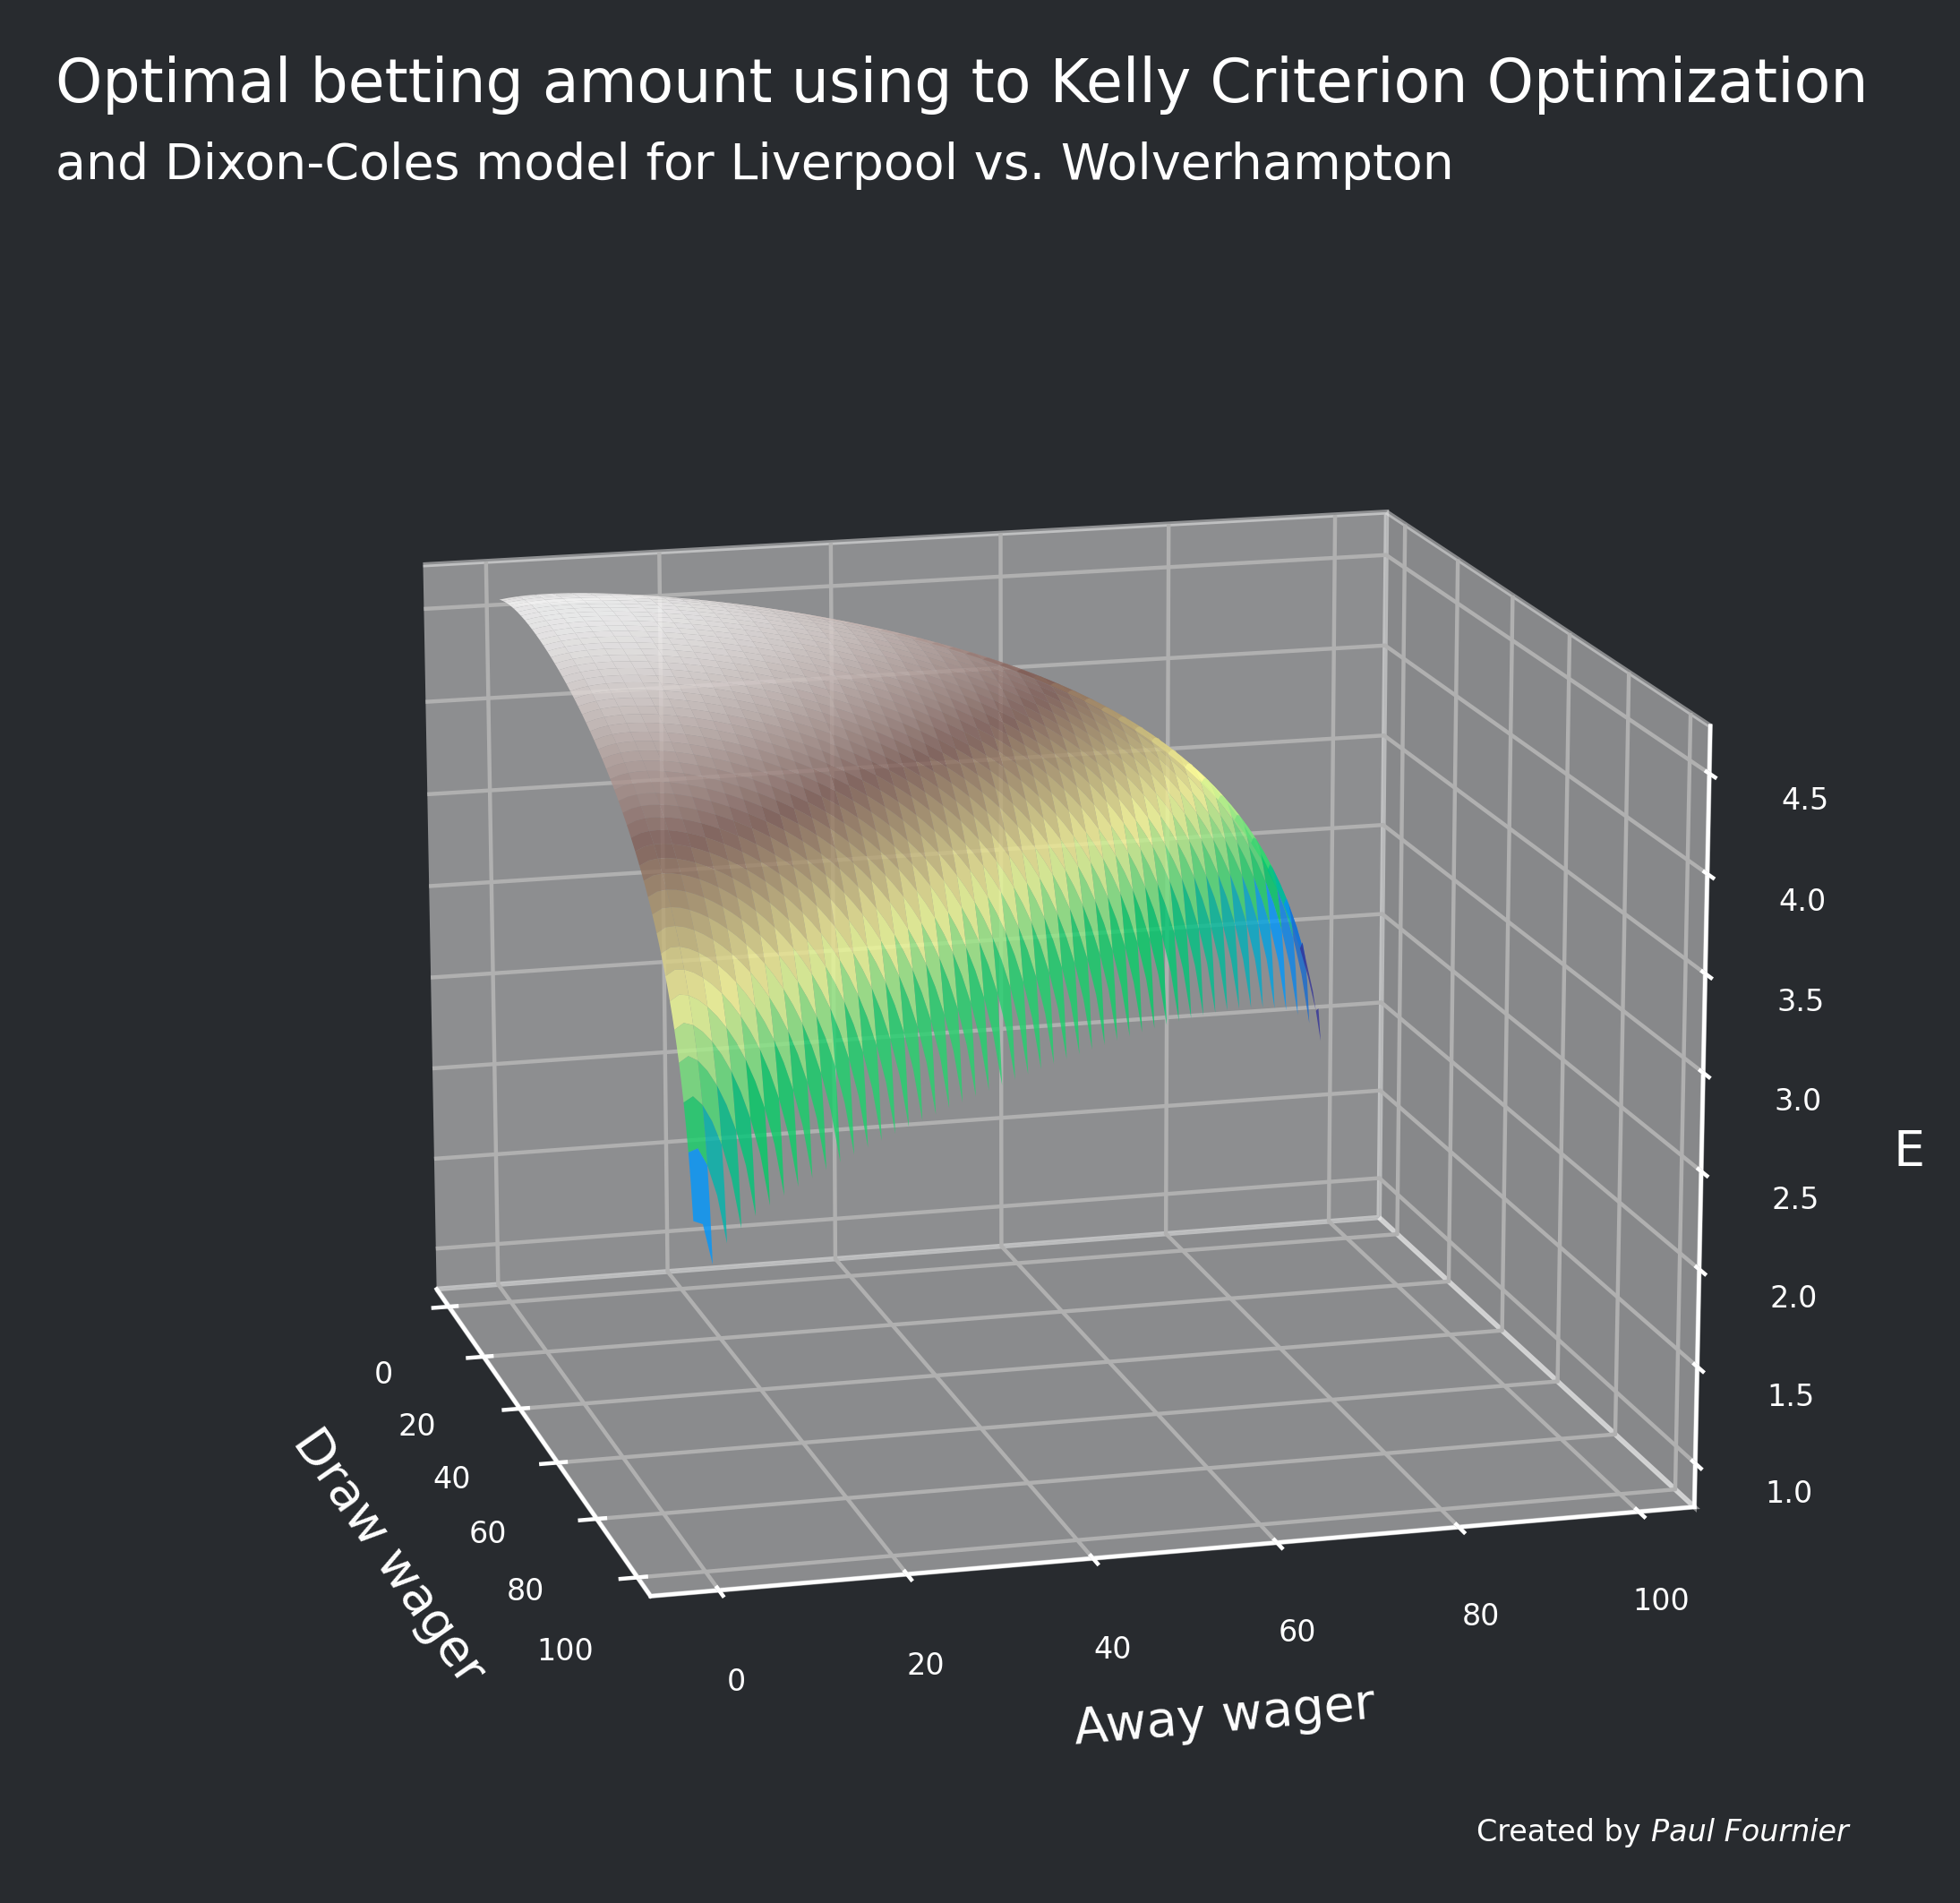

In [49]:
fig, ax = plt.subplots(tight_layout=True, subplot_kw=dict(projection='3d'))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.view_init(15, -15)

ax.plot_surface(
    xgrid,
    ygrid,
    E,
    cmap='terrain',
    alpha=.8
    )

ax.set_xlabel('Draw wager')
ax.xaxis.label.set_color('w')
ax.set_ylabel('Away wager')
ax.yaxis.label.set_color('w')
ax.set_zlabel('E')
ax.zaxis.label.set_color('w')

fig_text(
    x=0.08, y=1.075,
    s="Optimal betting amount using to Kelly Criterion Optimization",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.08, y=1.025,
    s="and Dixon-Coles model for Liverpool vs. Wolverhampton",
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.7, y=0.05,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

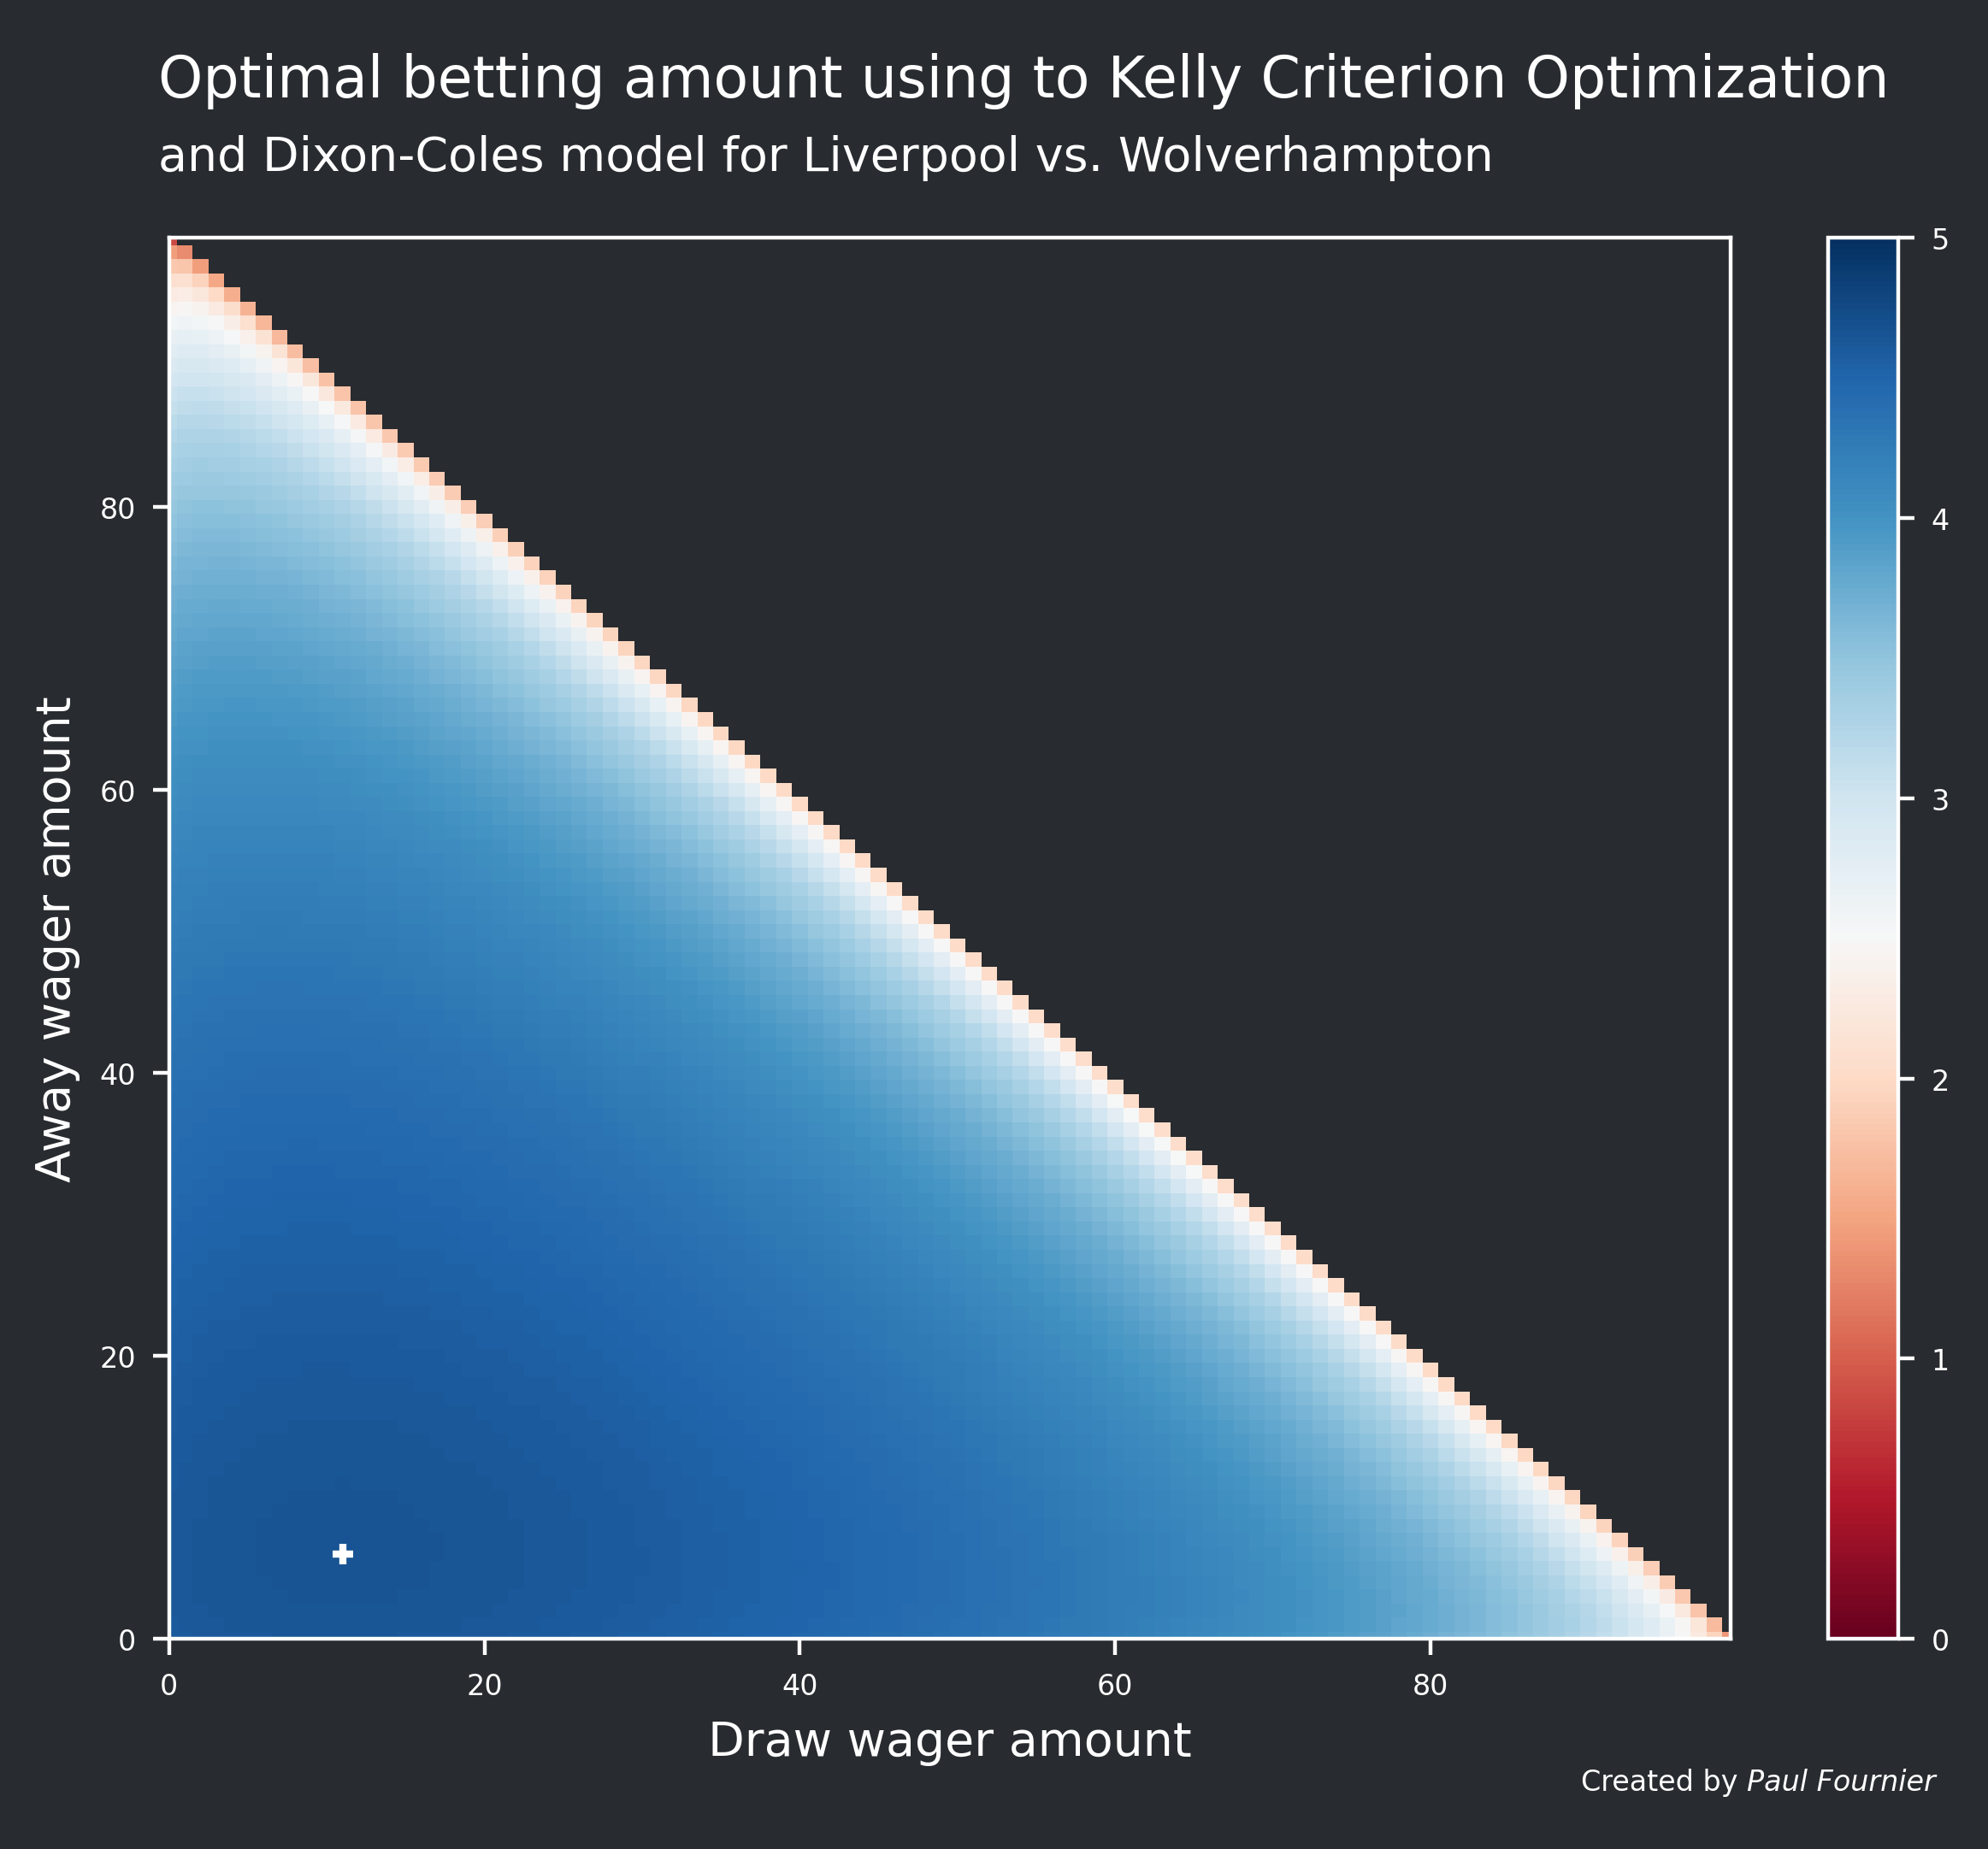

In [53]:
fig, ax = plt.subplots(tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

c = ax.pcolormesh(xgrid, ygrid, E, cmap='RdBu', vmin=0, vmax=5)
# set the limits of the plot to the limits of the data
ax.axis([xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()])
fig.colorbar(c, ax=ax)

ax.scatter(
    11,
    6,
    color='w',
    marker='+',
    s=20)

ax.set_xlabel('Draw wager amount')
ax.xaxis.label.set_color('w')
ax.set_ylabel('Away wager amount')
ax.yaxis.label.set_color('w')

fig_text(
    x=0.08, y=1.075,
    s="Optimal betting amount using to Kelly Criterion Optimization",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.08, y=1.025,
    s="and Dixon-Coles model for Liverpool vs. Wolverhampton",
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.73, y=0.03,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()